## Section 11 Demo: Model selection and regularization

In this section, we'll work with Ridge and Lasso regression, focusing on how to implement them and examining their prediction error and the coefficients that result from using these methods.

Model selection and regularization approaches give us a method to select which variables (i.e. features) to include in our model, as well as to select the value of the coefficients that should be associated with those variables. Cross-validation also allows us to select variables by providing a way to compare error across different models. 

Model selection and regularization are also related to OLS in that they provide different methods for choosing model coefficients. Rather than just minimizing the loss, techniques like Ridge or Lasso regression add a regularization term that penalizes the model if it includes too many features by pushing some of the coefficients to zero or close to zero.

Regularization methods like Ridge or Lasso can also work *with* cross-validation - for instance, in this lab, we're going to use cross-validation to tune the hyperparameter $\lambda$. We will use a random train-test split of the data to see how models with different values of $\lambda$ perform. Although we don't do it in this lab, a more systematic and rigorous way of evaluating different values of $\lambda$ would be to compare model performance using leave one out or k-fold cross validation.


### Setup

In [1]:
# Run this block.
import numpy as np
import pandas as pd
import sklearn

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
sns.set_context("talk")
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

### Section 1: EDA and data filtering

We will be working with a paper, Novotny et al. that focuses on land-use regression. Here's a quick summary of what it covers:

* The data includes GIS land-use characteristics from EPA land-monitoring and in situ NO2 measurements from satellite sensors.
* The goal of land-use regression (LUR) is to estimate outdoor air pollution geospatially across the contiguous United States.
* The reason for the high number of data points is that the data keeps track of readings from monitors at a high resolution, up to ~30 meters.

In [2]:
#run to load the dataset we'll be working with
df = pd.read_csv('data/BechleLUR_2006_allmodelbuildingdata.csv')

In [3]:
df.head()

,Monitor_ID,State,Latitude,Longitude,Observed_NO2_ppb,Predicted_NO2_ppb,WRF+DOMINO,Distance_to_coast_km,Elevation_truncated_km,Impervious_100,Impervious_200,Impervious_300,Impervious_400,Impervious_500,Impervious_600,Impervious_700,Impervious_800,Impervious_1000,Impervious_1200,Impervious_1500,Impervious_1800,Impervious_2000,Impervious_2500,Impervious_3000,Impervious_3500,Impervious_4000,Impervious_5000,Impervious_6000,Impervious_7000,Impervious_8000,Impervious_10000,Population_100,Population_200,Population_300,Population_400,Population_500,Population_600,Population_700,Population_800,Population_1000,Population_1200,Population_1500,Population_1800,Population_2000,Population_2500,Population_3000,Population_3500,Population_4000,Population_5000,Population_6000,Population_7000,Population_8000,Population_10000,Major_100,Major_200,Major_300,Major_400,Major_500,Major_600,Major_700,Major_800,Major_1000,Major_1200,Major_1500,Major_1800,Major_2000,Major_2500,Major_3000,Major_3500,Major_4000,Major_5000,Major_6000,Major_7000,Major_8000,Major_10000,Resident_100,Resident_200,Resident_300,Resident_400,Resident_500,Resident_600,Resident_700,Resident_800,Resident_1000,Resident_1200,Resident_1500,Resident_1800,Resident_2000,Resident_2500,Resident_3000,Resident_3500,Resident_4000,Resident_5000,Resident_6000,Resident_7000,Resident_8000,Resident_10000,Resident_10500,Resident_11000,Resident_11500,Resident_12000,Resident_12500,Resident_13000,Resident_13500,Resident_14000,total_100,total_200,total_300,total_400,total_500,total_600,total_700,total_800,total_1000,total_1200,total_1500,total_1800,total_2000,total_2500,total_3000,total_3500,total_4000,total_5000,total_6000,total_7000,total_8000,total_10000,total_10500,total_11000,total_11500,total_12000,total_12500,total_13000,total_13500,total_14000
0,04-013-0019-42602-1,AZ,33.48385,-112.14257,23.884706,20.986643,11.615223,313.0,0.304,59.4431,59.4715,59.4810,59.4572,59.3039,59.1636,59.0507,58.9488,58.7941,58.9821,59.2879,59.8456,60.1169,60.1553,59.7722,59.5908,59.5556,59.2200,58.3484,57.5475,56.3765,52.2642,3434.0000,3434.0000,3411.8328,3369.4805,3374.2180,3403.9201,3425.0499,3440.4236,3467.5636,3496.6767,3507.2187,3388.9482,3306.8511,3096.9563,2870.9081,2712.0688,2652.9409,2541.2515,2428.1611,2337.5601,2245.5723,2024.5460,0.00000,0.00000,0.00000,0.00000,0.49224,0.84872,1.11154,1.35858,3.48036,6.72288,10.45728,17.17240,21.46712,31.77685,50.76791,79.74268,104.89995,166.58362,231.04656,298.41773,384.37428,554.79507,0.61637,1.76406,3.64989,6.05967,9.08376,12.49667,16.72079,20.95306,28.19335,36.77423,56.07123,76.17936,92.75979,141.40171,208.14918,277.49442,360.92204,560.02672,803.90089,1089.93658,1404.00587,2083.12410,2269.08304,2454.55438,2635.14164,2843.33267,3069.31560,3254.15743,3433.87888,3623.34585,0.61637,1.76406,3.64989,6.05967,9.57600,13.34539,17.83233,22.31164,31.67371,43.49711,66.52851,93.35176,114.22691,173.17856,258.91709,357.23710,465.82199,726.61034,1034.94745,1388.35431,1788.38015,2637.91917,2862.73591,3096.99468,3339.22952,3609.20650,3896.25748,4150.54739,4396.96011,4651.18890
1,04-013-3002-42602-6,AZ,33.45793,-112.04601,25.089886,20.990096,11.472677,323.8,0.304,72.0000,72.0000,72.0000,72.0000,71.9109,71.6594,71.4787,71.4093,71.4899,71.6481,71.9319,71.8449,71.2728,69.4570,68.0373,66.6440,65.7764,63.4799,60.5909,59.0333,58.2535,55.1395,2715.9121,2820.9973,2857.7844,2882.9007,2922.6060,2955.1033,2980.2975,2975.5773,2858.6769,2713.3988,2540.6768,2411.3403,2336.4432,2171.0319,2067.0406,1998.7573,1939.4790,1826.4574,1728.7592,1683.7545,1683.8406,1652.0872,0.00000,0.16726,0.47770,0.70926,0.92816,3.44480,5.58398,7.46132,13.62402,26.06820,40.44928,51.82634,60.07474,79.14227,100.46330,130.76356,159.86952,232.42547,291.65556,383.84647,499.06352,705.01818,0.26126,1.14480,1.98903,4.33272,6.93099,9.68176,13.13134,17.11873,25.53028,36.59210,56.75135,83.25340,99.69127,149.45363,207.70180,272.08012,351.49761,549.40811,725.27587,947.93127,1231.98435,1857.31130,2029.32556,2196.75975,2384.41496,2579.46411,277

In [4]:
df['State'].value_counts()

CA    94
TX    41
PA    26
FL    14
LA    12
VA    11
NM    11
AZ     9
ND     9
MO     9
SC     8
NY     8
NJ     8
MA     8
WY     7
KY     7
NV     6
UT     6
TN     6
IL     6
IN     6
CO     5
OK     5
GA     5
KS     4
OH     3
MN     3
DC     3
SD     3
MI     3
CT     3
NH     2
MD     2
IA     2
NC     2
ME     2
AR     2
VT     2
WI     1
WA     1
DE     1
RI     1
ID     1
MT     1
Name: State, dtype: int64

In [5]:
df[df['State'] == 'KY']

,Monitor_ID,State,Latitude,Longitude,Observed_NO2_ppb,Predicted_NO2_ppb,WRF+DOMINO,Distance_to_coast_km,Elevation_truncated_km,Impervious_100,Impervious_200,Impervious_300,Impervious_400,Impervious_500,Impervious_600,Impervious_700,Impervious_800,Impervious_1000,Impervious_1200,Impervious_1500,Impervious_1800,Impervious_2000,Impervious_2500,Impervious_3000,Impervious_3500,Impervious_4000,Impervious_5000,Impervious_6000,Impervious_7000,Impervious_8000,Impervious_10000,Population_100,Population_200,Population_300,Population_400,Population_500,Population_600,Population_700,Population_800,Population_1000,Population_1200,Population_1500,Population_1800,Population_2000,Population_2500,Population_3000,Population_3500,Population_4000,Population_5000,Population_6000,Population_7000,Population_8000,Population_10000,Major_100,Major_200,Major_300,Major_400,Major_500,Major_600,Major_700,Major_800,Major_1000,Major_1200,Major_1500,Major_1800,Major_2000,Major_2500,Major_3000,Major_3500,Major_4000,Major_5000,Major_6000,Major_7000,Major_8000,Major_10000,Resident_100,Resident_200,Resident_300,Resident_400,Resident_500,Resident_600,Resident_700,Resident_800,Resident_1000,Resident_1200,Resident_1500,Resident_1800,Resident_2000,Resident_2500,Resident_3000,Resident_3500,Resident_4000,Resident_5000,Resident_6000,Resident_7000,Resident_8000,Resident_10000,Resident_10500,Resident_11000,Resident_11500,Resident_12000,Resident_12500,Resident_13000,Resident_13500,Resident_14000,total_100,total_200,total_300,total_400,total_500,total_600,total_700,total_800,total_1000,total_1200,total_1500,total_1800,total_2000,total_2500,total_3000,total_3500,total_4000,total_5000,total_6000,total_7000,total_8000,total_10000,total_10500,total_11000,total_11500,total_12000,total_12500,total_13000,total_13500,total_14000
155,21-019-0017-42602-1,KY,38.459167,-82.640556,9.656829,11.721402,6.263819,591.5,0.187,27.9461,29.4331,30.3603,30.8376,31.1245,31.3153,31.4510,31.5525,31.6320,31.0910,29.9214,28.9449,28.4653,27.4178,25.8117,23.7425,21.9194,19.0073,17.4488,16.4078,15.6162,13.9290,773.0,773.0000,825.4150,896.5458,940.2963,968.5283,986.6391,995.3855,1002.6692,998.3104,986.2809,978.8295,972.8364,926.3954,844.4098,757.5584,673.9526,527.3231,426.5641,362.8910,317.4911,262.1788,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.14465,0.56264,0.95575,1.37306,5.70641,17.51219,26.39295,41.22026,61.27940,83.22420,105.77037,132.56787,183.14643,0.24554,1.06783,3.28579,6.27007,9.57536,13.34685,16.90193,21.54447,33.16455,46.88937,69.85714,97.08816,116.57954,171.35191,227.18155,265.50534,295.05260,371.45724,467.96623,556.14483,662.69706,924.71944,997.61188,1075.20774,1155.11860,1232.57064,1312.11766,1395.44081,1465.67897,1538.89166,0.24554,1.06783,3.28579,6.27007,9.57536,13.34685,16.90193,21.54447,33.16455,47.03402,70.41978,98.04391,117.95260,177.05832,244.69374,291.89829,336.27286,432.73664,551.19043,661.91520,795.26493,1107.86587,1192.61723,1294.52797,1400.19621,1501.41340,1608.09575,1714.33725,1801.39316,1896.99631
156,21-029-0006-42602-1,KY,37.985556,-85.713056,7.692308,9.400235,4.827178,923.9,0.124,17.0000,18.0055,18.7771,19.3463,19.7799,20.1004,20.3432,20.5324,20.8066,21.0163,20.7410,19.7458,18.8482,16.7439,14.3044,12.4298,11.2135,9.4916,8.1955,7.2392,6.4346,5.6583,172.0,183.7453,187.6672,189.6272,190.8026,191.5860,192.1454,192.5649,192.4745,191.2226,191.7550,193.1765,192.8292,187.8664,185.2918,185.1385,184.4831,171.7677,152.0639,135.0775,123.0048,107.2986,0.00000,0.00000,0.00000,0.00000,0.58697,1.21504,2.02005,2.85514,4.25593,6.48630,15.58957,23.91688,28.15941,36.45087,42.26580,47.91489,53.25360,64.67103,77.36787,90.66179,106.07613,153.54561,0.19836,0.61703,1.18277,2.21958,3.79557,5.88026,7.35778,8.47111,11.18692,14.57235,18.80660,24.27237,27.32441,41.24811,58.83288,78.94873,99.43325,127.77992,161.77129,209.95739,261.19831,374.88505,406.00920,442.23595,478.26648,515.51313,557.98835,599.07060,642.10478,694.11241,0.19836,0.61703,1.18277,2.21958,4.38254,7.09530,9

We create a dataframe `df_model` that contains only the response and predictor variables (i.e. dropping Monitor_ID, State, Latitude, Longitude, and Predicted_NO2_ppb). The response variable is the observed NO2 concentration. 

Reminder: the target variable will allow us to estimate surface-level $NO_2$ levels at different points in space.

In [6]:
df_model = df.drop(['Monitor_ID', 'State', 'Latitude', 'Longitude','Predicted_NO2_ppb'],axis=1)
df_model.head()

,Observed_NO2_ppb,WRF+DOMINO,Distance_to_coast_km,Elevation_truncated_km,Impervious_100,Impervious_200,Impervious_300,Impervious_400,Impervious_500,Impervious_600,Impervious_700,Impervious_800,Impervious_1000,Impervious_1200,Impervious_1500,Impervious_1800,Impervious_2000,Impervious_2500,Impervious_3000,Impervious_3500,Impervious_4000,Impervious_5000,Impervious_6000,Impervious_7000,Impervious_8000,Impervious_10000,Population_100,Population_200,Population_300,Population_400,Population_500,Population_600,Population_700,Population_800,Population_1000,Population_1200,Population_1500,Population_1800,Population_2000,Population_2500,Population_3000,Population_3500,Population_4000,Population_5000,Population_6000,Population_7000,Population_8000,Population_10000,Major_100,Major_200,Major_300,Major_400,Major_500,Major_600,Major_700,Major_800,Major_1000,Major_1200,Major_1500,Major_1800,Major_2000,Major_2500,Major_3000,Major_3500,Major_4000,Major_5000,Major_6000,Major_7000,Major_8000,Major_10000,Resident_100,Resident_200,Resident_300,Resident_400,Resident_500,Resident_600,Resident_700,Resident_800,Resident_1000,Resident_1200,Resident_1500,Resident_1800,Resident_2000,Resident_2500,Resident_3000,Resident_3500,Resident_4000,Resident_5000,Resident_6000,Resident_7000,Resident_8000,Resident_10000,Resident_10500,Resident_11000,Resident_11500,Resident_12000,Resident_12500,Resident_13000,Resident_13500,Resident_14000,total_100,total_200,total_300,total_400,total_500,total_600,total_700,total_800,total_1000,total_1200,total_1500,total_1800,total_2000,total_2500,total_3000,total_3500,total_4000,total_5000,total_6000,total_7000,total_8000,total_10000,total_10500,total_11000,total_11500,total_12000,total_12500,total_13000,total_13500,total_14000
0,23.884706,11.615223,313.0,0.304,59.4431,59.4715,59.4810,59.4572,59.3039,59.1636,59.0507,58.9488,58.7941,58.9821,59.2879,59.8456,60.1169,60.1553,59.7722,59.5908,59.5556,59.2200,58.3484,57.5475,56.3765,52.2642,3434.0000,3434.0000,3411.8328,3369.4805,3374.2180,3403.9201,3425.0499,3440.4236,3467.5636,3496.6767,3507.2187,3388.9482,3306.8511,3096.9563,2870.9081,2712.0688,2652.9409,2541.2515,2428.1611,2337.5601,2245.5723,2024.5460,0.00000,0.00000,0.00000,0.00000,0.49224,0.84872,1.11154,1.35858,3.48036,6.72288,10.45728,17.17240,21.46712,31.77685,50.76791,79.74268,104.89995,166.58362,231.04656,298.41773,384.37428,554.79507,0.61637,1.76406,3.64989,6.05967,9.08376,12.49667,16.72079,20.95306,28.19335,36.77423,56.07123,76.17936,92.75979,141.40171,208.14918,277.49442,360.92204,560.02672,803.90089,1089.93658,1404.00587,2083.12410,2269.08304,2454.55438,2635.14164,2843.33267,3069.31560,3254.15743,3433.87888,3623.34585,0.61637,1.76406,3.64989,6.05967,9.57600,13.34539,17.83233,22.31164,31.67371,43.49711,66.52851,93.35176,114.22691,173.17856,258.91709,357.23710,465.82199,726.61034,1034.94745,1388.35431,1788.38015,2637.91917,2862.73591,3096.99468,3339.22952,3609.20650,3896.25748,4150.54739,4396.96011,4651.18890
1,25.089886,11.472677,323.8,0.304,72.0000,72.0000,72.0000,72.0000,71.9109,71.6594,71.4787,71.4093,71.4899,71.6481,71.9319,71.8449,71.2728,69.4570,68.0373,66.6440,65.7764,63.4799,60.5909,59.0333,58.2535,55.1395,2715.9121,2820.9973,2857.7844,2882.9007,2922.6060,2955.1033,2980.2975,2975.5773,2858.6769,2713.3988,2540.6768,2411.3403,2336.4432,2171.0319,2067.0406,1998.7573,1939.4790,1826.4574,1728.7592,1683.7545,1683.8406,1652.0872,0.00000,0.16726,0.47770,0.70926,0.92816,3.44480,5.58398,7.46132,13.62402,26.06820,40.44928,51.82634,60.07474,79.14227,100.46330,130.76356,159.86952,232.42547,291.65556,383.84647,499.06352,705.01818,0.26126,1.14480,1.98903,4.33272,6.93099,9.68176,13.13134,17.11873,25.53028,36.59210,56.75135,83.25340,99.69127,149.45363,207.70180,272.08012,351.49761,549.40811,725.27587,947.93127,1231.98435,1857.31130,2029.32556,2196.75975,2384.41496,2579.46411,2771.68495,2968.16660,3152.91688,3364.20733,0.26126,1.31206,2.46673,5.04198,7.85915,13.12656,18.71532,24.58005,39.15430,62.66030,97.20063,135.07974,159.76601,228.5

We have a lot of potential features in our dataset, and it's hard to visualize all of them in relation to our response variable. To gain some familiarity with the data, however, let's take a close look at a few. 

Below, we create a plot with 4 scatterplots, each showing a different feature on the x-axis and the response variable on the y-axis. Do you observe any trends or relationships? Visually, would you expect a model selection algorithm to prioritize or minimize any of these features? Why?

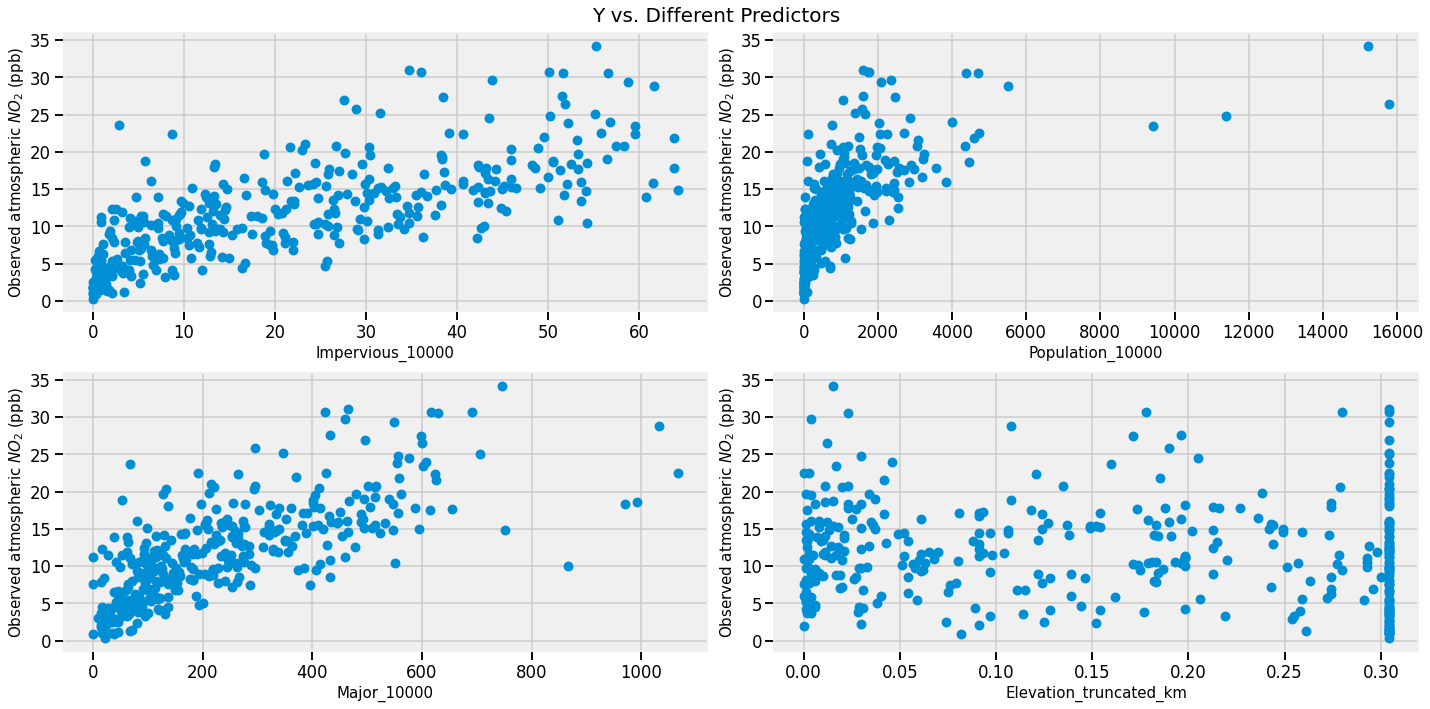

In [7]:
# Replace ellipses with your code
y = df['Observed_NO2_ppb'] # y axis variable
ylab = "Observed atmospheric $NO_2$ (ppb)" # y axis label

msize = 70 # marker size
afsize = 15 # axis font size
tfsize = 20 # title font size

plt.figure(figsize = (20,10))

plt.subplot(221)
plt.scatter(df['Impervious_10000'], y, s = msize)
plt.xlabel('Impervious_10000', fontsize = afsize)
plt.ylabel(ylab, fontsize = afsize)

plt.subplot(222)
plt.scatter(df['Population_10000'], y, s = msize)
plt.xlabel('Population_10000', fontsize = afsize)
plt.ylabel(ylab, fontsize = afsize)

plt.subplot(223)
plt.scatter(df['Major_10000'], y, s = msize)
plt.xlabel('Major_10000', fontsize = afsize)
plt.ylabel(ylab, fontsize = afsize)

plt.subplot(224)
plt.scatter(df['Elevation_truncated_km'], y, s = msize)
plt.xlabel('Elevation_truncated_km', fontsize = afsize)
plt.ylabel(ylab, fontsize = afsize)

plt.suptitle('Y vs. Different Predictors', fontsize = tfsize)

plt.subplots_adjust(top=0.5) # avoid overlapping title and plots
plt.tight_layout()

We should expect Imp_10000 and Major_10000 to be prioritized by a model selection algorithm, as they appear to have a stronger correlation with the outcome. Right?

### Standardizing your features
A **super-important** thing to do is to standardize your independent variables when using regularization methods, especially when the domains of the independent variables span dramatically different ranges.

Below, we use the `.describe()` method on the original `df_model` dataframe and examine the results. 

It's faily easy to provide at least two examples of features whose values span dramatically different ranges (i.e., at least one order of magnitude). All the impervious (aspalth) features range from 0 to around 100. Same goes for all population metrics, in order of several thousands.

In [8]:
df_model.describe()

,Observed_NO2_ppb,WRF+DOMINO,Distance_to_coast_km,Elevation_truncated_km,Impervious_100,Impervious_200,Impervious_300,Impervious_400,Impervious_500,Impervious_600,Impervious_700,Impervious_800,Impervious_1000,Impervious_1200,Impervious_1500,Impervious_1800,Impervious_2000,Impervious_2500,Impervious_3000,Impervious_3500,Impervious_4000,Impervious_5000,Impervious_6000,Impervious_7000,Impervious_8000,Impervious_10000,Population_100,Population_200,Population_300,Population_400,Population_500,Population_600,Population_700,Population_800,Population_1000,Population_1200,Population_1500,Population_1800,Population_2000,Population_2500,Population_3000,Population_3500,Population_4000,Population_5000,Population_6000,Population_7000,Population_8000,Population_10000,Major_100,Major_200,Major_300,Major_400,Major_500,Major_600,Major_700,Major_800,Major_1000,Major_1200,Major_1500,Major_1800,Major_2000,Major_2500,Major_3000,Major_3500,Major_4000,Major_5000,Major_6000,Major_7000,Major_8000,Major_10000,Resident_100,Resident_200,Resident_300,Resident_400,Resident_500,Resident_600,Resident_700,Resident_800,Resident_1000,Resident_1200,Resident_1500,Resident_1800,Resident_2000,Resident_2500,Resident_3000,Resident_3500,Resident_4000,Resident_5000,Resident_6000,Resident_7000,Resident_8000,Resident_10000,Resident_10500,Resident_11000,Resident_11500,Resident_12000,Resident_12500,Resident_13000,Resident_13500,Resident_14000,total_100,total_200,total_300,total_400,total_500,total_600,total_700,total_800,total_1000,total_1200,total_1500,total_1800,total_2000,total_2500,total_3000,total_3500,total_4000,total_5000,total_6000,total_7000,total_8000,total_10000,total_10500,total_11000,total_11500,total_12000,total_12500,total_13000,total_13500,total_14000
count,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.00000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000
mean,11.932308,5.870935,427.049864,0.155911,32.597564,32.587949,32.634152,32.663021,32.626588,32.580371,32.525231,32.460650,32.317949,32.156400,31.850225,31.487055,31.217791,30.496367,29.764125,29.056108,28.376363,27.090163,25.867014,24.779351,23.811889,22.136649,1433.821758,1430.463334,1423.707308,1414.852356,1411.272648,1411.609964,1409.734140,1407.673473,1403.852957,1402.107178,1399.497844,1390.817350,1384.556010,1368.099336,1344.364651,1315.577142,1289.202733,1236.102609,1178.340862,1128.923773,1077.398729,985.579170,0.033475,0.162976,0.377144,0.655965,1.000206,1.442346,1.970429,2.591989,4.023899,5.739974,8.793957,12.248378,14.802406,21.907391,30.185111,39.77327,50.525211,74.586284,101.699512,132.003409,165.737663,238.635357,0.168606,0.677750,1.540861,2.730538,4.283771,6.189923,8.429514,10.974601,16.

Luckily for us, `sklearn` has built a built-in method, `StandardScaler` that makes it easy to standardize our variables before we fit our regression models. You can read more about it [here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html ). In essence, `StandardScaler` takes in our array of features. For each feature (i.e., column), the difference between each element and the mean value of the feature is divided by the standard devation of the features, according to the following equation:

$$
X_{stnd} = \frac{X - \mu}{\sigma}
$$

where $\mu$ and $\sigma$ are the mean and standard deviation, respectively, of the feature $X$. 

[Side note: Strictly speaking, we should only use `StandardScaler` if our features are normally distributed. If that's not the case, `sklearn` offers other scaling methods. For further reading, [see this article](https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02 ).]

The following code block shows an example of how to use `StandardScaler` to standardize the first three features from the Novotny et. al data.

In [9]:
from sklearn.preprocessing import StandardScaler


novotny_3 = df_model.iloc[:,1:4] # We'll standardize the WRF+DOMINO, Distance_to_coast_km, and Elevation_truncated_km features

scaler = StandardScaler() # Initialize the StandardScaler
scaler.fit(novotny_3) # Fit the standard scaler for each feature
print(scaler.mean_) # Print the mean value of each feature

novotny_stnd = scaler.transform(novotny_3) # Standardize each features
novotny_stnd

[5.87093469e+00 4.27049864e+02 1.55910569e-01]


array([[ 1.05238647, -0.21374302,  1.23996121],
       [ 1.02627128, -0.19350253,  1.23996121],
       [ 0.57149871, -0.22236397,  1.23996121],
       ...,
       [-1.34649959,  2.10266807,  1.23996121],
       [-1.39026179,  2.05431579,  1.23996121],
       [-1.17838759,  2.07830452,  1.23996121]])

In the next section, we'll use `StandardScalar` to transform our features before creating models.

---

Now that we've loaded the data and done some visual exploration, we can think about how to choose which features to include in the model. Features can provide important information and predictive power. However, as we add more features to the model, we risk increasing its variance (meaning our model performs poorly with test data relative to training data). It also can be harder to make sense of a model with lots of features. Rather than throwing out features entirely, we can turn to a technique called regularization to reduce the variance of our model while still incorporating as much information about the data as possible.

More generally, we can adopt the framework of regularized loss minimization.

$$ \large \hat{\theta} = \arg \min_\theta \frac{1}{n} \sum_{i=1}^n \textbf{Loss}\left(y_i, \hat{y_i}\right) + \lambda \textbf{R}(\theta) $$

The regularization term $\textbf{R}(\theta)$ is essentially a penalty for complex and therefore higher variance models. The regularization parameter $\lambda$ determines the degree of regularization to apply and is typically determined through cross validation.

The two regularlization methods that we're exploring in this section (Ridge regression and Lasso regression) use different regularization terms $\textbf{R}(\theta)$.

### Section 2: L2 Regularization with Ridge Regression


Ridge regression (L2 regularization) uses the *penalty* term $\large R_{L^2}(\theta) = \sum_{k=1}^p (\theta_k)^2$, where $p$ is the number of model features.

Note that $\lambda$ is a tunable parameter - as the person creating the model, you can choose to increase or decrease $\lambda$ based on how much you want to penalize the addition of model features. The higher the value of $\lambda$, the more a model is penalized for the addition of features. A large $\lambda$ decreases the model's variance at the cost of increasing its bias.

**Important:** In scikit-learn, the value of $\lambda$ is passed in through the argument `alpha`.

#### Train-Test Split

We separate the `df_model` dataframe into train and test sets, with 25% of the data in the test set. Setting a `random_state` for replicability. 

We do this by setting `X` to the matrix of predictor variables (all quantitative columns in the dataframe except the response variable) and set `y` equal to the response variable `Observed_NO2_ppb`.

We also standardize your `X` variables using `StandardScalar`. Then apply `train_test_split` to `X` and `y` to split the data.

In [10]:

from sklearn.model_selection import train_test_split

X = df_model.drop(['Observed_NO2_ppb'],axis=1)

# Standardize the features
scaler = StandardScaler()
scaler.fit(X)
X_stnd = scaler.transform(X)

y = df_model.iloc[:,0]

X_train, X_test, y_train, y_test = train_test_split(X_stnd, y, test_size=0.25, random_state=1)

In [11]:
#run this to make sure you split the data correctly
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(276, 129) (276,) (93, 129) (93,)


### LinearRegression 

Below, we fit a `LinearRegression` model (without regularization) on the training data and print the resulting list of coefficients.

In [12]:
# YOUR CODE IN THIS CELL
from sklearn.linear_model import LinearRegression

lm = LinearRegression()
lm.fit(X_train,y_train)
lm_coefficients = lm.coef_

print(lm_coefficients)

[ 4.08399569e+00 -4.29333225e-01  1.19757265e+00  1.37866616e+01
 -2.28343608e+01  1.98803767e+01 -7.56783088e+00 -3.44216850e+01
  6.14198384e+01 -3.98071061e+01  2.93575365e+01 -5.94204368e+01
  7.26888782e+01 -6.80868842e+01  7.78964706e+01 -4.62547715e+01
 -9.06045803e+00  6.14565751e+01 -9.82922956e+01  7.66815419e+01
 -4.75754440e+01  1.00928919e+01  4.17413657e+01 -2.83619161e+01
 -2.69384858e+00  1.74502456e+00 -1.75305761e+00  1.05567278e+01
 -8.37476249e+01  1.75063753e+02 -1.67708601e+02  1.25967557e+02
 -1.38275799e+02  1.39233371e+02 -9.46423278e+01  8.86812782e+01
 -5.96519803e+01 -2.06176813e+01  6.54499633e+01 -6.97973278e+01
  5.19981024e+01 -2.19318917e+01 -2.49517980e+01  4.24224657e+01
 -2.67171973e+01  1.30155664e+01 -2.88339311e+00 -3.17017331e-01
  1.08591088e+00 -1.91876641e+00  2.96341016e+00 -6.62378253e-01
 -6.55290286e+00  7.86569782e+00 -2.11255719e+00 -4.65481807e-01
 -4.50258303e-02  4.77587506e+00 -6.87127820e+00  3.15128556e+00
 -4.13953641e+00  7.11646

### RidgeRegression

Below, we import and create a Ridge regression model with `alpha` value set to 1. 

We then fit the model to the training data, and return a list of the coefficients that the model associates with each feature in the training data. 

The [scikit-learn documentation for Ridge()](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) is helpful here.

In [13]:
# YOUR CODE IN THIS CELL
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=10)
ridge.fit(X_train,y_train)
ridge_coefficients = ridge.coef_

print(ridge_coefficients)

[ 3.57419524e+00 -7.41928296e-01  1.24919348e+00  1.35336090e-01
 -6.05050829e-02 -1.27545084e-01 -1.33566037e-01 -1.07448728e-01
 -5.30736281e-02 -1.91698451e-02  2.68911141e-02  9.90941067e-02
  2.02976188e-01  3.05374311e-01  4.09699664e-01  4.22234452e-01
  3.98171257e-01  3.52422391e-01  2.76285406e-01  2.46867006e-01
  1.32918265e-01  8.98771776e-02  8.10649611e-02  5.82861035e-02
 -7.03201038e-02 -5.94924330e-01 -4.37180924e-01 -2.70287750e-01
 -1.36056670e-01  3.32007691e-03  1.01748833e-01  1.99774528e-01
  2.97260065e-01  5.06612665e-01  5.23795954e-01  4.24780359e-01
  2.38521958e-01  1.00597345e-01 -1.53754296e-01 -2.31219393e-01
 -3.04587195e-01 -3.60934508e-01 -2.41070521e-01 -5.26074545e-02
  1.71416340e-03  1.57605009e-01  4.45944691e-01 -8.41006888e-02
  1.08893875e-01  7.19108438e-02 -4.12635779e-02  2.78832417e-01
 -5.36903772e-01  5.13670866e-01  3.82997162e-01 -1.01573129e-01
  2.11931089e-01  6.21924860e-01 -4.53694365e-01 -2.67131742e-01
 -1.59733436e-01  4.42762

### Plotting our coefficients from LinearRegression and RidgeRegression
Run the code below to generate a bar chart that shows the coefficient values from simple linear regression in blue, and from ridge regression in red. Then, in the markdown cell below, comment on the results. Can you explain your observations based on your understanding of L2 ridge regression?

*Hint* If you're having a hard time making out some of the coefficients, try re-creating the plot using a log scale. 

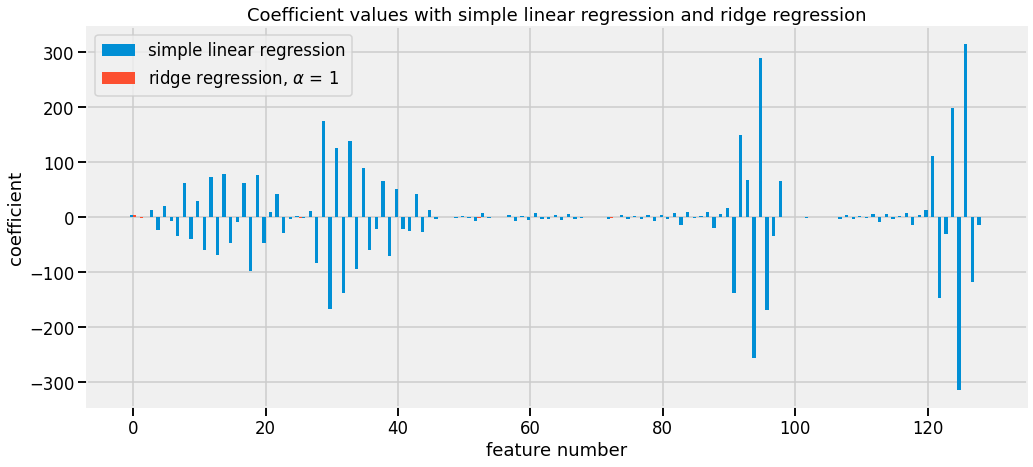

In [14]:
# run this cell
ind = np.arange(len(lm_coefficients))
width = 0.5

plt.figure(figsize = (15,7))

plt.bar(ind-(width/2), width = width, height = lm_coefficients, label = "simple linear regression")
plt.bar(ind+(width/2), width = width, height = ridge_coefficients, label = r"ridge regression, $\alpha$ = 1")
plt.xlabel("feature number")
plt.ylabel("coefficient")
plt.title("Coefficient values with simple linear regression and ridge regression")
plt.legend()
plt.show()

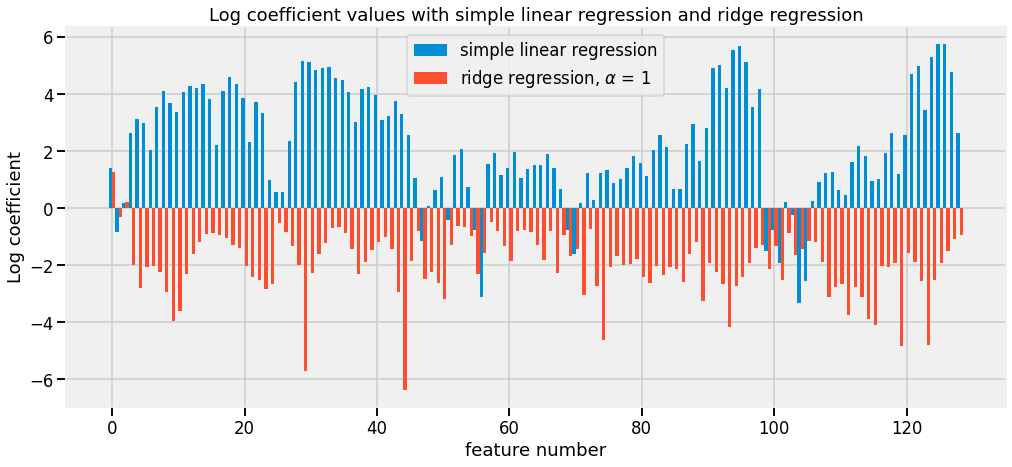

In [15]:
# run this cell
ind = np.arange(len(lm_coefficients))
width = 0.5

plt.figure(figsize = (15,7))

plt.bar(ind-(width/2), width = width, height = np.log(np.abs(lm_coefficients)), label = "simple linear regression")
plt.bar(ind+(width/2), width = width, height = np.log(np.abs(ridge_coefficients)), label = r"ridge regression, $\alpha$ = 1")
plt.xlabel("feature number")
plt.ylabel("Log coefficient")
plt.title("Log coefficient values with simple linear regression and ridge regression")
plt.legend()
plt.show()

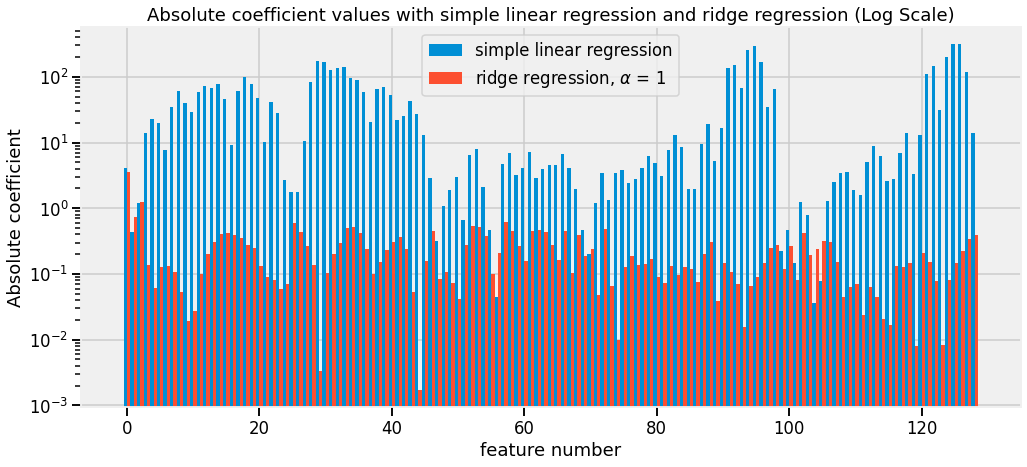

In [16]:
# run this cell
ind = np.arange(len(lm_coefficients))
width = 0.5

plt.figure(figsize = (15,7))

plt.bar(ind-(width/2), width = width, height = np.abs(lm_coefficients), label = "simple linear regression")
plt.bar(ind+(width/2), width = width, height = np.abs(ridge_coefficients), label = r"ridge regression, $\alpha$ = 1")
plt.yscale("log")
plt.xlabel("feature number")
plt.ylabel("Absolute coefficient")
plt.title("Absolute coefficient values with simple linear regression and ridge regression (Log Scale)")
plt.legend()
plt.show()


We just observed how the Ridge Regression model generates coefficients when `alpha` is set to one. Complete the following code which generalizes the fitting and predicting process we just did above for various values of `alpha`.

Then, we calculate the mean squared error (MSE) between our predictions and the test dataset. The MSE in this case is a measure of the accuracy of our predictions.

[11.983604522618336, 10.502251862994616, 9.929256531933492, 9.584990763967555, 10.412063276976054, 14.448460238647968, 19.979343104684688, 36.3015125624063, 43.91630926800665, 44.93257410687717, 45.03752695381413, 45.0480565046562]


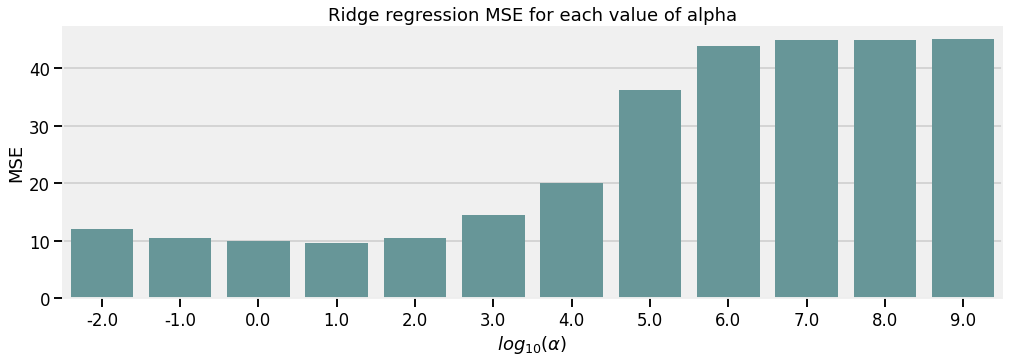

In [17]:
# Replace ellipses with your code
from sklearn.metrics import mean_squared_error
alphas = [1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9]
mses = []

for a in alphas:
    model = Ridge(alpha=a)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    mses.append(mean_squared_error(y_pred, y_test))

print(mses)


# Create a plot
a_log = np.log10(alphas)

plt.figure(figsize = (15,5))
sns.barplot(x=a_log, y=mses, color = 'cadetblue')
plt.xlabel(r'$log_{10}(\alpha)$')
plt.ylabel('MSE')
plt.title('Ridge regression MSE for each value of alpha');

### Optimal alpha

What is the lowest MSE observed and which value of alpha did it come from? What value of $\lambda$ does that correspond to? Does the value of $\lambda$ that minimizes MSE more heavily or less heavily penalize additional coefficients than our initial value of $\lambda$ that we used to produce the plot earlier?

In [18]:
# Your code here

print('lowest MSE', np.min(mses), '; alpha: ', alphas[np.argmin(mses)])

lowest MSE 9.584990763967555 ; alpha:  10.0


Yes, it does. Our original alpha was 1.

### Section 3: L1 Regularization with Lasso Regression

While ridge regression minimizes coefficients, it incorporates *all* the features into your model. It won't actually drive any coefficients to 0 (unless $\lambda$ = $\infty$!). This can make your model less *interpretable* - for instance, in the case of the model we created in Section 2, we have over 120 non-zero coefficients and thus over 120 features.

Lasso regression (also called L1 Regularization) avoids the issue of including too many unimportant variables by using a model formulation that can drive some coefficients to 0.

Lasso regression uses the *penalty* term $\large R_{L^1}(\theta) = \sum_{k=1}^p \Big|\theta_k\Big|$, where $p$ is the number of model features.

Let's repeat the steps we did above for Ridge Regression, this time for Lasso Regression. Below, we create a Lasso model with an `alpha` of 1 and fit on the X_train and y_train dataset.

In [19]:
# YOUR CODE IN THIS CELL
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=1)
lasso.fit(X_train,y_train)
lasso_coefficients = lasso.coef_
print(lasso_coefficients)

[ 2.91473792 -0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.67775051  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.01915487
  0.          0.          0.33495264  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.16374227  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0. 

Run the cell below to output a plot that shows the coefficients from the simple linear regression in part 2, the ridge regression in part 2, and the lasso regression above side-by-side. The coefficients are plotted on a logarithmic scale.

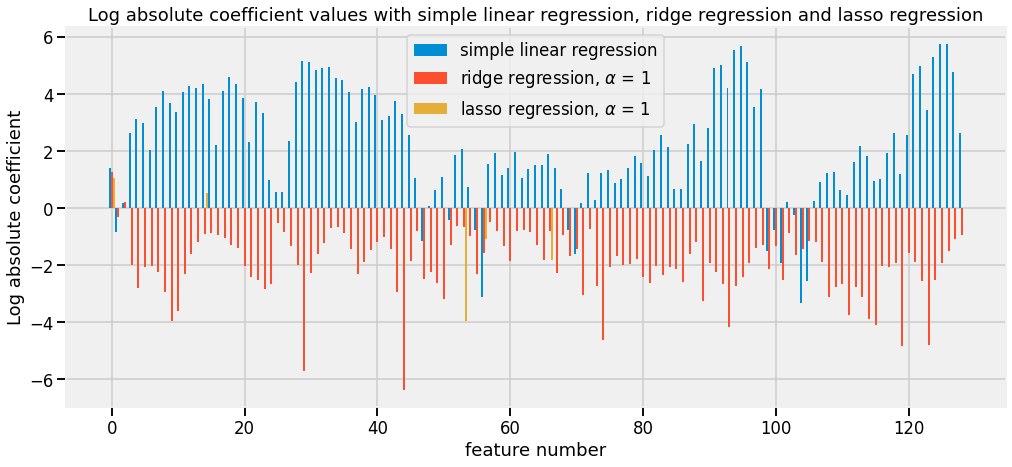

In [20]:
# run this cell
ind = np.arange(len(lm_coefficients))
width = 0.3

plt.figure(figsize = (15,7))

plt.bar(ind-width, width = width, height = np.log(np.abs(lm_coefficients)), label = "simple linear regression")
plt.bar(ind, width = width, height = np.log(np.abs(ridge_coefficients)), label = r"ridge regression, $\alpha$ = 1")
plt.bar(ind+width, width = width, height = np.log(np.abs(lasso_coefficients)), label = r"lasso regression, $\alpha$ = 1")
plt.xlabel("feature number")
plt.ylabel("Log absolute coefficient")
plt.title("Log absolute coefficient values with simple linear regression, ridge regression and lasso regression")
plt.legend()
plt.show()

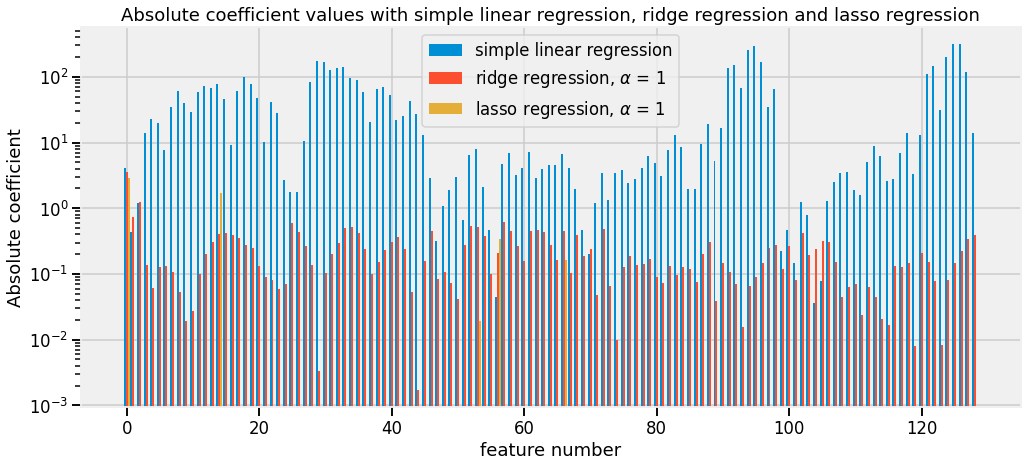

In [21]:
# run this cell
ind = np.arange(len(lm_coefficients))
width = 0.3

plt.figure(figsize = (15,7))

plt.bar(ind-width, width = width, height = np.abs(lm_coefficients), label = "simple linear regression")
plt.bar(ind, width = width, height = np.abs(ridge_coefficients), label = r"ridge regression, $\alpha$ = 1")
plt.bar(ind+width, width = width, height = np.abs(lasso_coefficients), label = r"lasso regression, $\alpha$ = 1")
plt.yscale("log")
plt.xlabel("feature number")
plt.ylabel("Absolute coefficient")
plt.title("Absolute coefficient values with simple linear regression, ridge regression and lasso regression")
plt.legend()
plt.show()

It appears that only 5 variables have 'survived' the lasso, as it forced less relevant variables to 0 - coefs!

Now, we can ask ourselves: what proportion of the datasets features are "ignored" by this lasso model? What are the column names of the features that are **not** ignored by this lasso model?

In [22]:
prop_ignored = 1- np.count_nonzero(lasso_coefficients) / len(lasso_coefficients)
print('Prop ignored:',prop_ignored)

Prop ignored: 0.9612403100775194


We can now look back to our very first plot (4 scatterplots). Were any of those features ignored or included by the lasso model?

In [23]:
X_train.shape

(276, 129)

In [24]:
X.shape

(369, 129)

In [25]:
cols_included = X.columns[lasso_coefficients !=0 ]
print('Columns included: ', cols_included.to_list())

Columns included:  ['WRF+DOMINO', 'Impervious_1800', 'Major_700', 'Major_1200', 'Major_7000']


'WRF+DOMINO'

Remember how we calculated the test MSE for different values of $\alpha$ for the RidgeRegression?

Now, we're going to write a function that automates that process, taking as input a list of alphas `alphas` and a model (`Ridge` or `Lasso`).

In [26]:
def calculate_mses(alphas, Model):
    """
    Input:
        alphas (array): contains floats of various alpha values
        Model (sklearn model): the type of sklearn model on which to fit the data
    Output:
        an array of floats containing the mean-squared-errors from the predictions
    """
    mses = []

    for a in alphas:
        # Your code here
        model = Model(alpha=a)
        model.fit(X_train,y_train)
        y_pred = model.predict(X_test)
        mses.append(mean_squared_error(y_pred, y_test))
    return mses

In [27]:
# YOUR CODE IN THIS CELL
#alphas = ...
lasso_mses = calculate_mses(alphas, Lasso)

In [28]:
lasso_mses

[9.707514985344893,
 9.08935523423302,
 12.58534598613699,
 45.049226840488956,
 45.049226840488956,
 45.049226840488956,
 45.049226840488956,
 45.049226840488956,
 45.049226840488956,
 45.049226840488956,
 45.049226840488956,
 45.049226840488956]

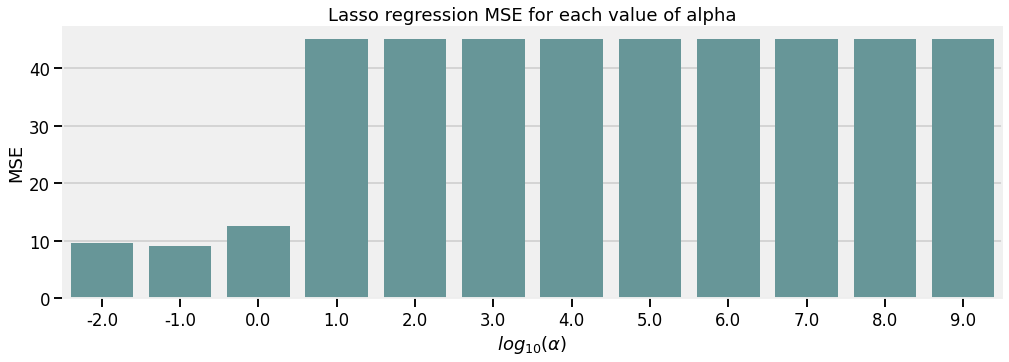

In [29]:
# Create a plot
a_log = np.log10(alphas)

plt.figure(figsize = (15,5))
sns.barplot(x=a_log, y=lasso_mses, color = 'cadetblue')
plt.xlabel(r'$log_{10}(\alpha)$')
plt.ylabel('MSE')
plt.title('Lasso regression MSE for each value of alpha');

#### Compare Models 

At last, we can compare how the best Ridge regression model and the best Lasso regression model perform relative to simple linear regression with respect to the mean squared error. We should ask ourselves: Which model has the lowest error?

Best Ridge: Alpha = 10, MSE = 9.929256531933824

Best Lasso: Alpha = 0.1, MSE =  9.089355234233016

Further Reading:

Regularization - https://www.textbook.ds100.org/ch/16/reg_intro.html
    
This notebook was developed by Alex McMurry, Kevin Marroquin, and Melissa Ly from Data Science Modules: http://data.berkeley.edu/education/modules.

It was adopoted to ECON 148: Data Science for Economists by UGSI Peter F. Grinde-Hollevik by consent of Professor Duncan Callaway.

